# **Obtención y acondicionamiento del dataset**

In [1]:
#Instalación de kaggle para acceder al dataset alojado sus servidores e importación de files para subir API Token
! pip install -q kaggle #Instalación de librería Kaggle
from google.colab import files #Para importar archivos

In [2]:
#Carga de API Token, llamada kaggle.json, se encuentra alojado en equipo local
files.upload() #Se importa el API Token de Kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanmaferos","key":"6773d116d393343b0b3ad521ed2c74d6"}'}

In [3]:
#Acondicionamiento de la carpeta, descarga y descompresión del dataset para ser utilizado
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ #Crea un directorio llamado Kaggle y copia el token
! chmod 600 ~/.kaggle/kaggle.json #Cambia los permisos del archivo
! kaggle datasets download -d kmader/synthetic-word-ocr #Descarga del dataset
! mkdir train #Creación de la carpeta train
! unzip synthetic-word-ocr.zip #Descomprimir información en carpeta creada train

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: train/images/000000275742.jpg  
  inflating: train/images/000000275743.jpg  
  inflating: train/images/000000275744.jpg  
  inflating: train/images/000000275745.jpg  
  inflating: train/images/000000275746.jpg  
  inflating: train/images/000000275747.jpg  
  inflating: train/images/000000275748.jpg  
  inflating: train/images/000000275749.jpg  
  inflating: train/images/000000275750.jpg  
  inflating: train/images/000000275751.jpg  
  inflating: train/images/000000275752.jpg  
  inflating: train/images/000000275753.jpg  
  inflating: train/images/000000275754.jpg  
  inflating: train/images/000000275755.jpg  
  inflating: train/images/000000275756.jpg  
  inflating: train/images/000000275757.jpg  
  inflating: train/images/000000275758.jpg  
  inflating: train/images/000000275759.jpg  
  inflating: train/images/000000275760.jpg  
  inflating: train/images/000000275761.jpg  
  inflating: train/images/0000002

# **Importación de librerías y procesamiento de etiquetas**

In [4]:
#Importación de librerías necesarias para la construcción del modelo
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np

In [5]:
#Definición de rutas para Colab
raiz_dir = '../content/'
img_dir = '../content/train/images/'
#Carga de las etiquetas hechas para el dataset
ruta = os.path.join(raiz_dir, 'annotation.json')
with open(ruta, 'r') as f:
    etiquetas = json.load(f)

In [6]:
img_df = pd.DataFrame(etiquetas['images']) #Dataframe con id, nombre de la imagen y dimensiones
etiq_df = pd.DataFrame(etiquetas['annotations']) #Dataframe con id, id de la imagen, segmentación, área, coordenadas, categoría
comp_df = pd.merge(etiq_df, img_df, how='left', left_on = 'image_id', right_on='id').dropna() #Unión de los anteriores dataframe, cruzados por id de imagen

In [ ]:
img_df.sample(2) #Observación de dos muestras aleatorias

,id,file_name,width,height
335,93532,000000093532.jpg,300,300
10966,158580,000000158580.jpg,300,300


In [ ]:
etiq_df.sample(2) #Observación de dos muestras aleatorias

,id,image_id,segmentation,area,bbox,category_id,iscrowd
1950597,1880400,220615,"[[171, 190, 171, 251, 134, 251, 134, 218, 106,...",3041.0,"[134, 106, 117, 65]",100,0
156059,657275,77096,"[[88.0, 123.0, 51.0, 123.0, 51.0, 110.0, 43.0,...",3032.0,"[43.0, 43.0, 80.0, 48.0]",100,0


In [ ]:
comp_df.sample(2) #Observación de dos muestras aleatorias

,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
76328,695963,81606,"[[129, 159, 70, 159, 69, 133, 129, 132, 129, 1...",1577.0,"[69, 69, 90, 60]",100,0,81606,000000081606.jpg,300,300
196506,864210,101385,"[[169.0, 300.0, 169.0, 257.0, 207.0, 257.0, 20...",2541.0,"[169.0, 169.0, 131.0, 57.0]",100,0,101385,000000101385.jpg,300,300


# **Conversión de polígonos en máscaras**

In [7]:
from matplotlib.path import Path
from skimage.color import label2rgb
def etiq_a_segment(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]),range(in_img.shape[1]),indexing='ij') # Obtención de dos array con puntos xy a partir de vectores de coordenadas
    segment = np.zeros(in_img.shape[:2]) # Creación de matriz de ceros
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        xy_path = Path(xy_vec)
        segment += xy_path.contains_points(np.stack([yy.ravel(),xx.ravel()],-1)).reshape(segment.shape)
    return segment

# **Separación de datos para entrenamiento y validación**

In [8]:
from sklearn.model_selection import train_test_split # Función para la separación de los datos, en datos de entrenamiento y datos de validación 
entrenamiento_ids, validacion_ids = train_test_split(img_df['id'], test_size = 0.25)
train_df = comp_df[comp_df['image_id'].isin(entrenamiento_ids)]
valid_df = comp_df[comp_df['image_id'].isin(validacion_ids)]

# **Generación de lotes**

In [9]:
# Generación de lotes con envío de máxima cantidad controlada por condicional y yield
def generador_lote(in_df, tam_lote): 
    grupos = list(in_df.groupby('image_id'))
    salida_img, salida_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(grupos):
            img_data = imread(os.path.join(img_dir, c_df['file_name'].values[0]))
            salida_img += [img_data]
            salida_seg += [np.expand_dims(etiq_a_segment(img_data, c_df), -1)]
            if len(salida_img)>=tam_lote:
                yield (np.stack(salida_img, 0)/255.0).astype(np.float32), np.stack(salida_seg, 0).astype(np.float32)
                salida_img, salida_seg = [], []
valid_gen = generador_lote(valid_df, 8)

<ipython-input-9-7b679ea61eae>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(grupos):


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


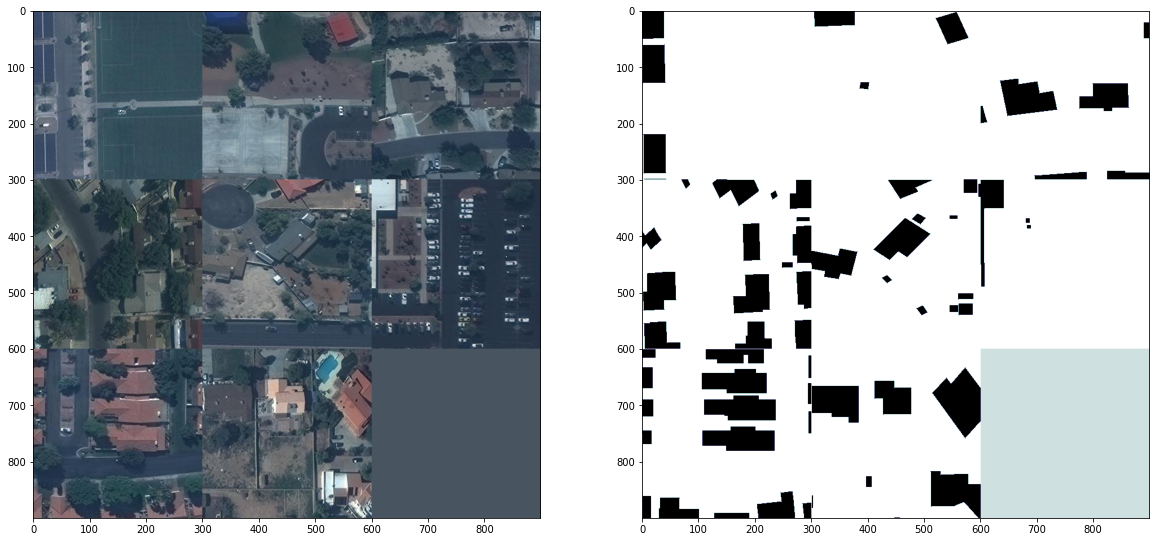

In [10]:
# Crea un montaje con las imágenes predispuestas para ello
from skimage.util import montage
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage(t_y[:, :, :, 0]), cmap = 'bone_r')

# **Definición de la red neuronal**

In [11]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.2
BATCH_SIZE = 16

In [12]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input') # Capa de entrada, imagen RGB
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer) # Adición de ruido gaussiano, útil para evitar overfitting
pp_in_layer = layers.BatchNormalization()(pp_in_layer) # Normalización de la entrada

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 300, 300, 3)  0          ['RGB_Input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 300, 300, 3)  12         ['gaussian_noise[0][0]']         
 alization)                                                                                       
                                                                                              

# **Definición de métricas y pérdidas del modelo**

In [13]:
# Configuración de las métricas y pérdidas del modelo
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1): 
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)
def dice_p_bce(in_gt, in_pred):
  return 0.05*binary_crossentropy(in_gt, in_pred) + dice_loss(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True) # Para guardar pesos

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6) # Reducir tasa de aprendizaje cuando val_dice_coef pare de mejorar
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # Parar cuando val_dice_coef pare de mejorar
callbacks_list = [checkpoint, early, reduceLROnPlat]

# **Entrenamiento del modelo**

In [15]:
valid_gen = generador_lote(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit_generator(generador_lote(train_df, BATCH_SIZE),
                             use_multiprocessing=True,
                             steps_per_epoch=min(entrenamiento_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=2, 
                             validation_data = valid_gen,
                             validation_steps = min(entrenamiento_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list,
                            workers=2)]

<ipython-input-15-2dc375a2a444>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = [seg_model.fit_generator(generador_lote(train_df, BATCH_SIZE),
<ipython-input-9-7b679ea61eae>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(grupos):


Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: 0.6495 - dice_coef: 0.4244 - binary_accuracy: 0.6848 - true_positive_rate: 0.6533
Epoch 1: val_dice_coef improved from -inf to 0.35333, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 144s 1s/step - loss: 0.6495 - dice_coef: 0.4244 - binary_accuracy: 0.6848 - true_positive_rate: 0.6533 - val_loss: 0.7993 - val_dice_coef: 0.3533 - val_binary_accuracy: 0.3522 - val_true_positive_rate: 0.8005 - lr: 1.0000e-04
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: 0.6142 - dice_coef: 0.4636 - binary_accuracy: 0.7245 - true_positive_rate: 0.6635
Epoch 2: val_dice_coef improved from 0.35333 to 0.42523, saving model to seg_model_weights.best.hdf5
100/100 [==============================] - 110s 1s/step - loss: 0.6142 - dice_coef: 0.4636 - binary_accuracy: 0.7245 - true_positive_rate: 0.6635 - val_loss: 0.7048 - val_dice_coef: 0.4252 - val_binary_accuracy: 0.5761 - val_true_

# **Resultados**

x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0
1/1 [==============================] - 0s 416ms/step


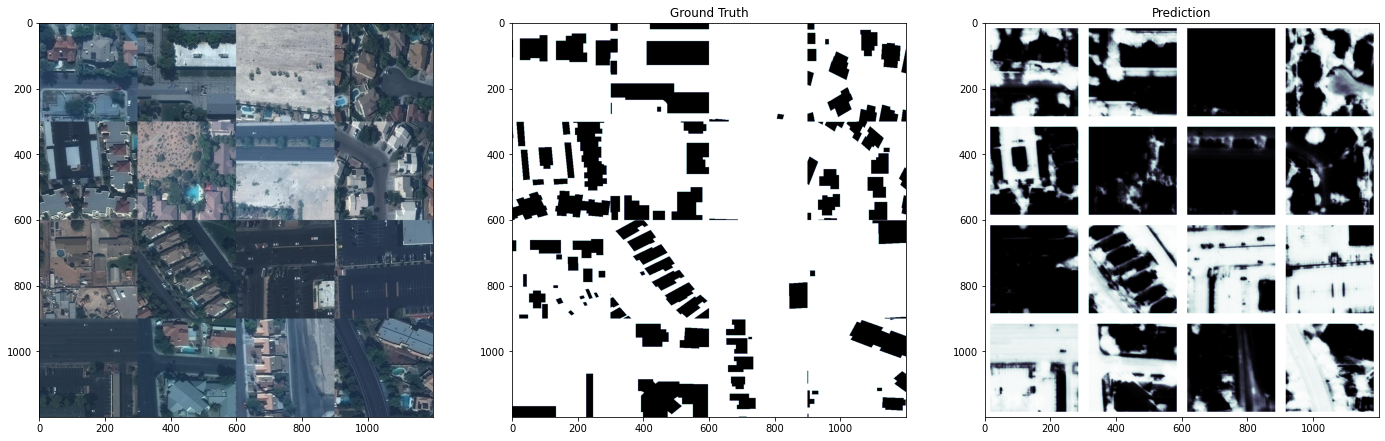

In [16]:
seg_model.load_weights(weight_path)
seg_model.save('full_best_model.h5')
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)